In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import torch.nn.functional as F
import tensorflow as tf

In [2]:
# Load the dataset

file_path = "AmesHousing.csv"  # Update this with your file path

data = pd.read_csv(file_path)



#show all colums and rows

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)



# Display the first few rows

data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Assuming 'data' is your DataFrame as shown in the previous code.

threshold = 0.65

missing_percentages = data.isnull().sum() / len(data)

columns_to_drop = missing_percentages[missing_percentages > threshold].index

data = data.drop(columns=columns_to_drop)

print(f"Columns dropped due to more than {threshold*100}% missing values:\n{columns_to_drop}")

# Now 'data' contains only the columns where missing values percentage is less than or equal to 65%.

Columns dropped due to more than 65.0% missing values:
Index(['Alley', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')


In [4]:
# Numerical columns ke liye missing values fill karna
numerical_cols = data.select_dtypes(include=np.number).columns
for col in numerical_cols:
  if data[col].isnull().any():
    data[col] = data[col].fillna(data[col].median())

# Categorical columns ke liye missing values fill karna
categorical_cols = data.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
  if data[col].isnull().any():
    data[col] = data[col].fillna(data[col].mode()[0])

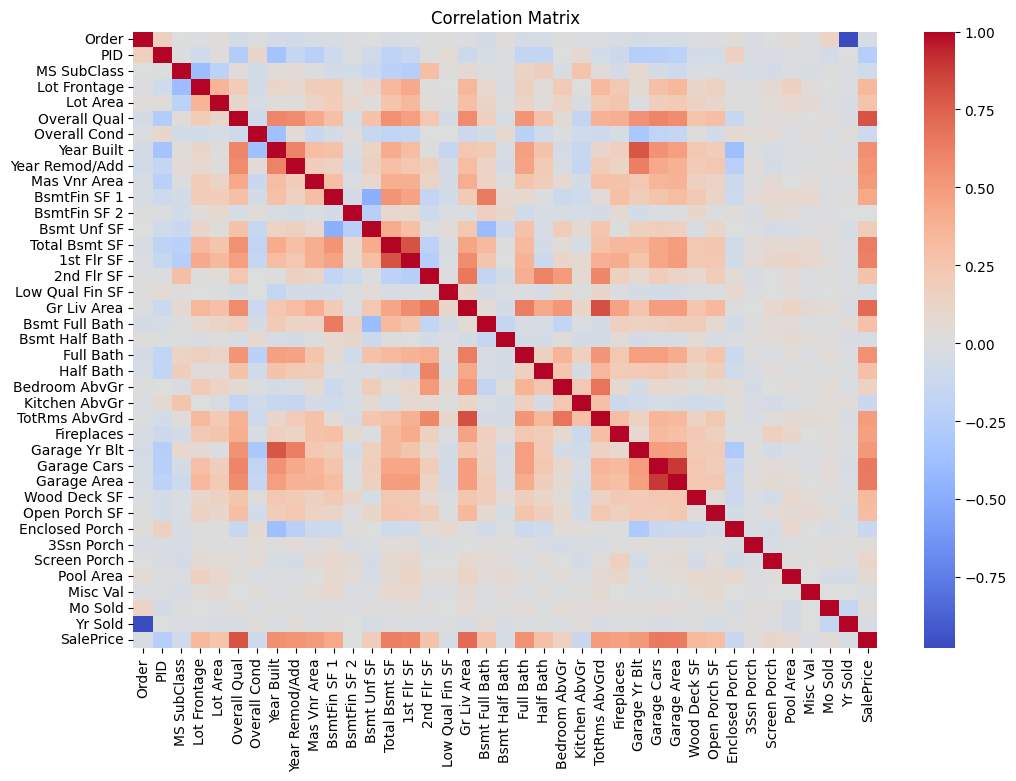

In [5]:
# Correlation matrix

plt.figure(figsize=(12, 8))

# Select only numerical features for correlation analysis

numerical_data = data.select_dtypes(include=['number'])

sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=False)

plt.title("Correlation Matrix")

plt.show()

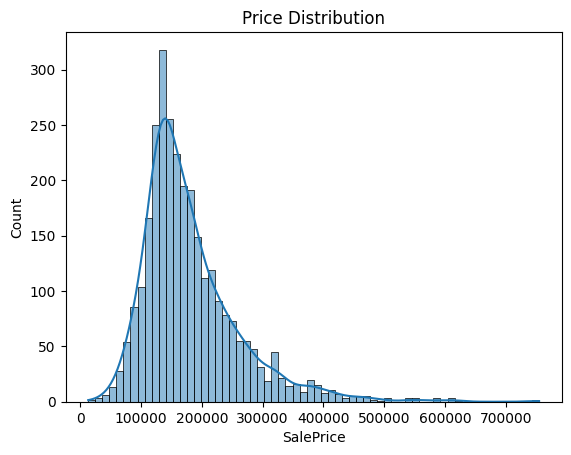

In [6]:
# Price distribution

sns.histplot(data['SalePrice'], kde=True)

plt.title("Price Distribution")

plt.show()

In [ ]:
# Separate numerical and categorical features

numerical_cols = data.select_dtypes(include=np.number).columns

categorical_cols = data.select_dtypes(exclude=np.number).columns

# Identify and handle skewed numerical features

for col in numerical_cols:

    if data[col].skew() > 0.5:  # Adjust the skew threshold as needed

        data[col] = np.log1p(data[col]) # Log transformation

# Impute numerical missing values using median (more robust to outliers)

for col in numerical_cols:

    if data[col].isnull().any():

        data[col].fillna(data[col].median(), inplace=True)

# Impute categorical missing values with a new category

for col in categorical_cols:

    if data[col].isnull().any():

        data[col] = data[col].fillna('Missing')  # Create a new category


# One-hot encode categorical features (after imputation)

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True) #drop_first to avoid multicollinearity

Epoch [1/50], Loss: 1.2593
Epoch [2/50], Loss: 1.2557
Epoch [3/50], Loss: 1.2521
Epoch [4/50], Loss: 1.2484
Epoch [5/50], Loss: 1.2445
Epoch [6/50], Loss: 1.2403
Epoch [7/50], Loss: 1.2357
Epoch [8/50], Loss: 1.2307
Epoch [9/50], Loss: 1.2251
Epoch [10/50], Loss: 1.2189
Epoch [11/50], Loss: 1.2119
Epoch [12/50], Loss: 1.2041
Epoch [13/50], Loss: 1.1954
Epoch [14/50], Loss: 1.1856
Epoch [15/50], Loss: 1.1747
Epoch [16/50], Loss: 1.1628
Epoch [17/50], Loss: 1.1497
Epoch [18/50], Loss: 1.1355
Epoch [19/50], Loss: 1.1203
Epoch [20/50], Loss: 1.1042
Epoch [21/50], Loss: 1.0877
Epoch [22/50], Loss: 1.0709
Epoch [23/50], Loss: 1.0544
Epoch [24/50], Loss: 1.0385
Epoch [25/50], Loss: 1.0237
Epoch [26/50], Loss: 1.0104
Epoch [27/50], Loss: 0.9988
Epoch [28/50], Loss: 0.9890
Epoch [29/50], Loss: 0.9809
Epoch [30/50], Loss: 0.9742
Epoch [31/50], Loss: 0.9686
Epoch [32/50], Loss: 0.9639
Epoch [33/50], Loss: 0.9597
Epoch [34/50], Loss: 0.9559
Epoch [35/50], Loss: 0.9523
Epoch [36/50], Loss: 0.9487
E

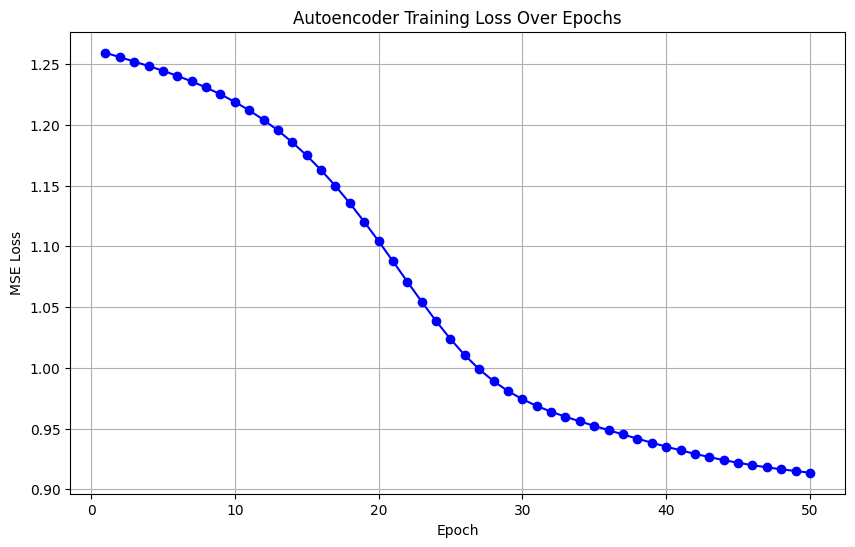

Epoch [1/100], Loss: 0.9097
Epoch [2/100], Loss: 0.8522
Epoch [3/100], Loss: 0.7975
Epoch [4/100], Loss: 0.7447
Epoch [5/100], Loss: 0.6932
Epoch [6/100], Loss: 0.6427
Epoch [7/100], Loss: 0.5929
Epoch [8/100], Loss: 0.5439
Epoch [9/100], Loss: 0.4960
Epoch [10/100], Loss: 0.4493
Epoch [11/100], Loss: 0.4047
Epoch [12/100], Loss: 0.3630
Epoch [13/100], Loss: 0.3249
Epoch [14/100], Loss: 0.2912
Epoch [15/100], Loss: 0.2628
Epoch [16/100], Loss: 0.2405
Epoch [17/100], Loss: 0.2246
Epoch [18/100], Loss: 0.2151
Epoch [19/100], Loss: 0.2109
Epoch [20/100], Loss: 0.2099
Epoch [21/100], Loss: 0.2098
Epoch [22/100], Loss: 0.2086
Epoch [23/100], Loss: 0.2050
Epoch [24/100], Loss: 0.1990
Epoch [25/100], Loss: 0.1910
Epoch [26/100], Loss: 0.1818
Epoch [27/100], Loss: 0.1726
Epoch [28/100], Loss: 0.1640
Epoch [29/100], Loss: 0.1562
Epoch [30/100], Loss: 0.1495
Epoch [31/100], Loss: 0.1440
Epoch [32/100], Loss: 0.1398
Epoch [33/100], Loss: 0.1367
Epoch [34/100], Loss: 0.1346
Epoch [35/100], Loss: 0

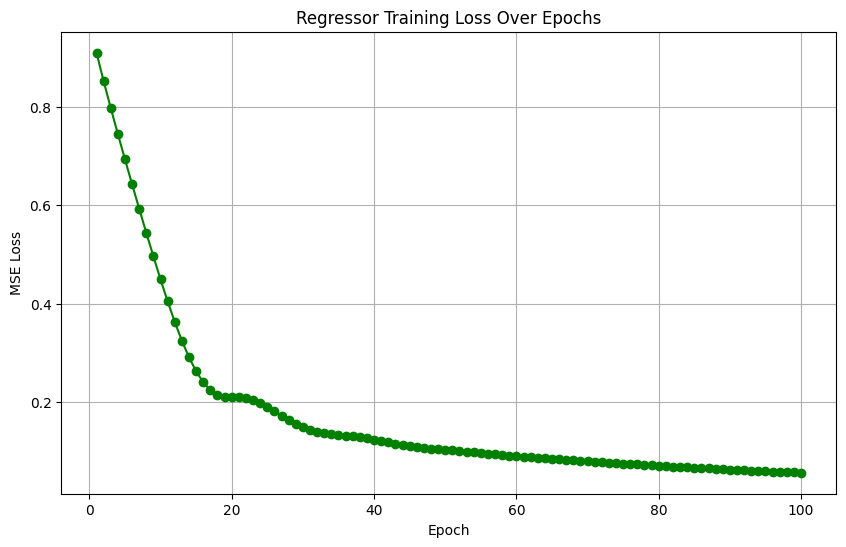

First three scaled y_test values: [161000. 116000. 196500.]
First three scaled predicted values: [159931.11677249 108793.33619992 199415.62072856]
First three original SalePrices: [215000 105000 172000]
First three rescaled y_test values: [215000.         154906.83229814 262406.83229814]
First three rescaled predicted values: [213572.60935457 145283.02660238 266300.36308473]


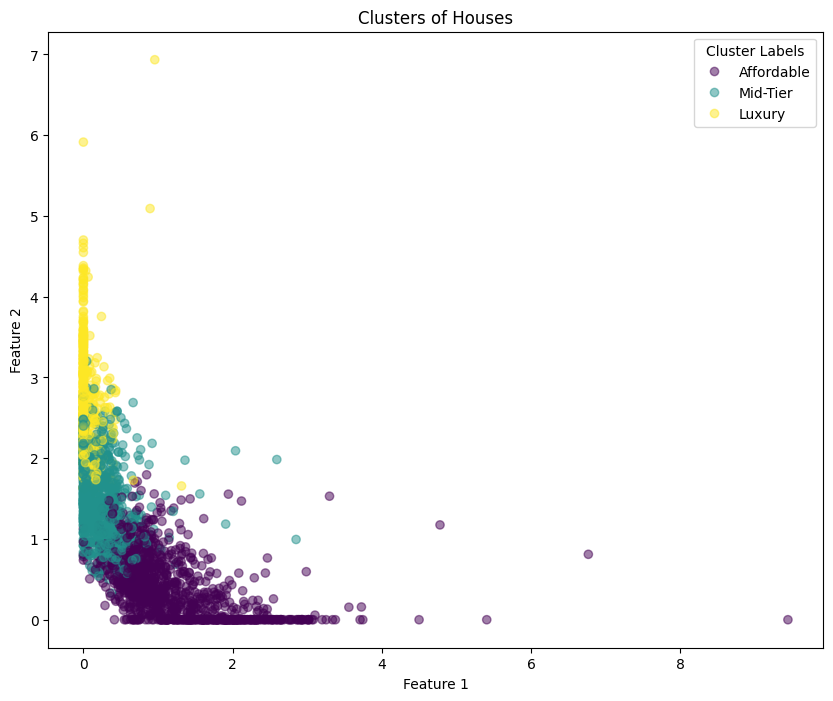

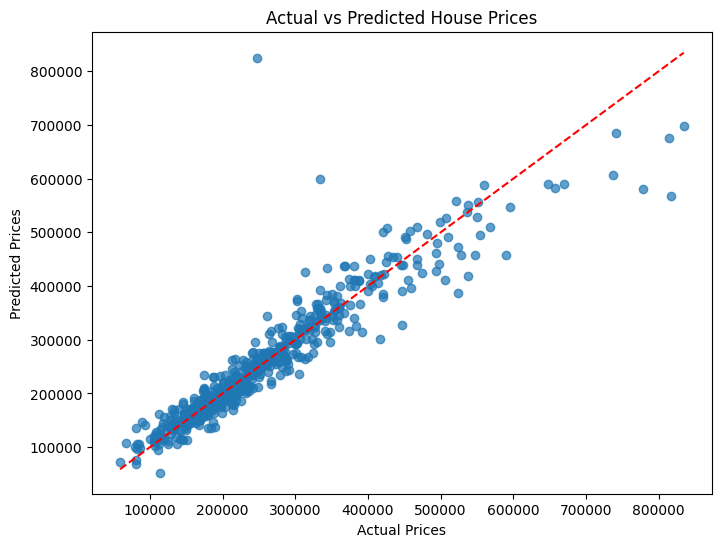

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import torch.nn.functional as F
import tensorflow as tf

# Load the dataset
file_path = "AmesHousing.csv"  # Update this with your file path
data_og = pd.read_csv(file_path)

# Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Assuming 'data' is your DataFrame as shown in the previous code.
threshold = 0.65

class HousingData:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()

    def preprocess(self):
        data = self.df
        # Drop rows with missing values (if any)
        threshold = 0.65
        missing_percentages = data.isnull().sum() / len(data)
        columns_to_drop = missing_percentages[missing_percentages > threshold].index
        data = data.drop(columns=columns_to_drop)

        numerical_cols = data.select_dtypes(include=np.number).columns
        for col in numerical_cols:
            if data[col].isnull().any():
                data[col] = data[col].fillna(data[col].median())

        # Impute categorical missing values with a new category
        categorical_cols = data.select_dtypes(exclude=np.number).columns
        for col in categorical_cols:
            if data[col].isnull().any():
                data[col] = data[col].fillna('Missing')

        # One-hot encode categorical features (after imputation)
        data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

        # Feature scaling (after handling missing values)
        numerical_data = data[numerical_cols]
        scaled_numerical_data = self.scaler1.fit_transform(numerical_data)
        data[numerical_cols] = scaled_numerical_data

        # Separate features and target
        X = data.drop('SalePrice', axis=1)
        y = data['SalePrice']

        # Split the data into training and test sets
        return train_test_split(X, y, test_size=0.2, random_state=42)

# Autoencoder Model
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(TabularAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Regressor Model
class HousePriceRegressor(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training functions
def train_autoencoder(model, data, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    loss_history = []  # Track loss over epochs

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        # Store loss for visualization
        loss_history.append(loss.item())

        # Print loss for each epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    # Visualize the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_history, marker='o', color='blue')
    plt.title('Autoencoder Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    return model

def train_regressor(model, X_train, y_train, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    loss_history = []  # Track loss over epochs

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        # Store loss for visualization
        loss_history.append(loss.item())

        # Print loss for each epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    # Visualize the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_history, marker='o', color='green')
    plt.title('Regressor Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    return model


# Visualization functions
def visualize_clusters(encoded_data, clusters, y_true, cluster_labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.title("Clusters of Houses")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Create color legend based on clusters
    handles, labels = scatter.legend_elements()

    # Add the cluster labels with colors to the legend
    plt.legend(handles, [cluster_labels[i] for i in np.unique(clusters)], title="Cluster Labels")

    plt.show()



def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs Predicted House Prices")
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    data = HousingData("AmesHousing.csv")
    X_train, X_test, y_train, y_test = data.preprocess()

    # Convert to PyTorch tensors (ensure only numeric columns are selected)
    X_train_numeric = X_train.select_dtypes(include=[np.number])
    X_test_numeric = X_test.select_dtypes(include=[np.number])

    X_train_tensor = torch.FloatTensor(X_train_numeric.values)
    X_test_tensor = torch.FloatTensor(X_test_numeric.values)

    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)

    # Initialize models
    input_dim = X_train_tensor.shape[1]  # Update to match the actual number of features
    autoencoder = TabularAutoencoder(input_dim)
    regressor = HousePriceRegressor(input_dim + 1)  # +1 for cluster feature

    # Train Autoencoder
    autoencoder = train_autoencoder(autoencoder, X_train_tensor)

    # Clustering using encoded features
    encoded_features = autoencoder.encoder(X_train_tensor).detach().numpy()
    kmeans = KMeans(n_clusters=3, random_state=42).fit(encoded_features)
    train_clusters = kmeans.predict(encoded_features)

    # Map clusters to 'Luxury', 'Mid-Tier', 'Affordable'
    cluster_labels = {0: 'Affordable', 1: 'Mid-Tier', 2: 'Luxury'}
    cluster_names = [cluster_labels[cluster] for cluster in train_clusters]

    # Combine features with cluster labels for supervised learning
    X_train_combined = np.hstack((X_train_numeric.values, train_clusters.reshape(-1, 1)))

    # Train Regressor
    X_train_combined_tensor = torch.FloatTensor(X_train_combined)
    regressor = train_regressor(regressor, X_train_combined_tensor, y_train_tensor)

    # Validation
    encoded_features_test = autoencoder.encoder(X_test_tensor).detach().numpy()
    test_clusters = kmeans.predict(encoded_features_test)
    X_test_combined = np.hstack((X_test_numeric.values, test_clusters.reshape(-1, 1)))
    X_test_combined_tensor = torch.FloatTensor(X_test_combined)

    regressor.eval()
    predictions = regressor(X_test_combined_tensor).detach().numpy().squeeze()

    # Inverse transform the predictions and y_test
    predictions_dataset_like = np.zeros(shape=(len(predictions), X_train_numeric.shape[1] + 1))  # +1 for y
    predictions_dataset_like[:, X_train_numeric.shape[1]] = predictions  # last column
    predictions_original_scale = data.scaler1.inverse_transform(predictions_dataset_like)[:, X_train_numeric.shape[1]]  # last column

    y_test_dataset_like = np.zeros(shape=(len(y_test), X_train_numeric.shape[1] + 1))  # +1 for y
    y_test_dataset_like[:, X_train_numeric.shape[1]] = y_test  # last column
    y_test_original_scale = data.scaler1.inverse_transform(y_test_dataset_like)[:, X_train_numeric.shape[1]]  # last column

    # Calculate the scaling factor
    #original_sale_prices = data_og['SalePrice'].iloc[0]  # Get a representative original value
    original_sale_prices = data_og['SalePrice'].values[0]
    scaled_y_test_first_value = y_test_original_scale[0]  # First scaled value from y_test

    scaling_factor = original_sale_prices / scaled_y_test_first_value

    # Rescale y_test and predictions
    rescaled_y_test = y_test_original_scale * scaling_factor
    rescaled_predicted = predictions_original_scale * scaling_factor

    # Print values for manual scaling
    print(f"First three scaled y_test values: {y_test_original_scale[:3]}")
    print(f"First three scaled predicted values: {predictions_original_scale[:3]}")
    print(f"First three original SalePrices: {data_og['SalePrice'].iloc[:3].values}")
    print(f"First three rescaled y_test values: {rescaled_y_test[:3]}")
    print(f"First three rescaled predicted values: {rescaled_predicted[:3]}")

    # Visualizations
    visualize_clusters(encoded_features, train_clusters, y_train, cluster_labels)
    plot_actual_vs_predicted(rescaled_y_test, rescaled_predicted)


In [23]:
# Baseline predictions using the mean of the training target values
baseline_pred = np.full_like(rescaled_y_test, np.mean(rescaled_y_test))

# Metrics for the baseline
baseline_mse = mean_squared_error(rescaled_y_test, baseline_pred)
baseline_mae = mean_absolute_error(rescaled_y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

# Print baseline metrics
print("Baseline Model (Mean Prediction):")
print(f"Mean Squared Error (MSE): {baseline_mse:.2f}")
print(f"Mean Absolute Error (MAE): {baseline_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {baseline_rmse:.2f}")


Baseline Model (Mean Prediction):
Mean Squared Error (MSE): 14297718186.27
Mean Absolute Error (MAE): 88952.63
Root Mean Squared Error (RMSE): 119573.07


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(rescaled_y_test, rescaled_predicted)
mae = mean_absolute_error(rescaled_y_test, rescaled_predicted)
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error (MSE): 1732862313.44
Mean Absolute Error (MAE): 22370.71
Root Mean Squared Error (RMSE): 41627.66
